<a href="https://colab.research.google.com/github/Tyler-Hattori/fretboard_ai/blob/third/Tones2Tab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import

In [1]:
import numpy as np
from numpy import random
import torch
from torch import nn
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import MultiHeadAttention, LayerNormalization, Layer, Dense, Dropout, Flatten, Embedding, Add
import os
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### params

In [19]:
T = 48
Q = 8 # T/Q should be an integer
N = int(T/Q)
D = 64
dff = 4*D
H = 8
L = 6
dropout_rate = 0.1
batch_size = 32
t2t_vocab_length = pow(2,Q)
t2t_output_dim = 25
t2t_mute_prob = 0.05
t2t_epochs = 10
A = 440 # Hz
guitar = [[A*pow(2,(-29+i)/12) for i in range(24)],
          [A*pow(2,(-24+i)/12) for i in range(24)],
          [A*pow(2,(-19+i)/12) for i in range(24)],
          [A*pow(2,(-14+i)/12) for i in range(24)],
          [A*pow(2,(-9+i)/12) for i in range(24)],
          [A*pow(2,(-5+i)/12) for i in range(24)]]

### helper functions

In [9]:
def freq2bin(freq):
  bin_ceils = [(440*2**((i-29)/12) + 440*2**((i-28)/12))/2 for i in range(T)]
  for i in range(T):
    if freq < bin_ceils[i]: return i
  return T

In [10]:
def freqs2tones(freqs):
  # length T array of only 0s and 1s
  tones = [0 for i in range(T)]
  for i in range(len(freqs)):
    if freqs[i] != 0:
      bin = freq2bin(freqs[i])
      tones[bin] = 1

  # convert length T binary array to length N sequence of tokens. Tokens are made by converting sets of T/N binary entries in tones to decimal
  tokens = [0 for i in range(N)]
  binaries = [pow(2,i) for i in range(Q)]
  for i in range(N):
    b = tones[i*Q:i*Q+Q]
    tokens[i] = np.inner(binaries,b)

  return tokens

In [11]:
def tab2freqs(tab):
  freqs = [guitar[i][tab[i]-1] if tab[i] != 0 else 0 for i in range(6)]
  return freqs2tones(freqs)

In [12]:
def next_key(chords):
  next = [[[0 for i in range(3)] for j in range(6)] for k in range(6)]
  for i in range(6):
    for j in range(6):
      next[i][j] = chords[i][j].copy()
      next[i][j][2] = next[i][j][2] + 1
    if next[i][4][2] == 12:
      next[i].pop()
      next[i].insert(0,next[i][4].copy())
      next[i][0][2] = next[i][0][2] - 12
  return next

In [13]:
def chord2tab(chord,mute_prob=t2t_mute_prob):
  m = 0
  tab = [m for i in range(6)]
  color = chord[0]
  shape = chord[1]
  fret = chord[2]

  if color == 0: # major chords
    if shape == 0: tab = [m,4,3,1,2,1]
    elif shape == 1: tab = [m,1,3,3,3,1]
    elif shape == 2: tab = [4,3,1,1,4,4]
    elif shape == 3: tab = [1,3,3,2,1,1]
    elif shape == 4: tab = [m,m,1,3,4,3]
  elif color == 1: # minor chords
    if shape == 0: tab = [m,4,2,1,2,m]
    elif shape == 1: tab = [m,1,3,3,2,1]
    elif shape == 2: tab = [4,2,1,1,4,4]
    elif shape == 3: tab = [1,3,3,1,1,1]
    elif shape == 4: tab = [m,m,1,3,4,2]

  tab = [tab[i] if random.rand() > mute_prob else m for i in range(6)]

  return [tab[i] + fret if tab[i] != m else m for i in range(6)]

In [14]:
# example converting a chord in tab representation to a tokenized tones vector
tab2freqs([0,4,3,1,2,1])

[0, 145, 32, 1, 0, 0]

### tones2tab dataset

In [15]:
def make_tones2tab_dataset():
  # specify csf chord representations
  c = [[[0,0,0],[0,1,3],[0,2,5],[0,3,8],[0,4,10],[0,0,12]], # 1
      [[1,4,0],[1,0,2],[1,1,5],[1,2,7],[1,3,10],[1,4,12]], # 2
      [[1,3,0],[1,4,2],[1,0,4],[1,1,7],[1,2,9],[1,3,12]], # 3
      [[0,3,1],[0,4,3],[0,0,5],[0,1,8],[0,2,10],[0,3,13]], # 4
      [[0,2,0],[0,3,3],[0,4,5],[0,0,7],[0,1,10],[0,2,12]], # 5
      [[1,1,0],[1,2,2],[1,3,5],[1,4,7],[1,0,9],[1,1,12]]] # 6
  csharp = next_key(c)
  d = next_key(csharp)
  dsharp = next_key(d)
  e = next_key(dsharp)
  f = next_key(e)
  fsharp = next_key(f)
  g = next_key(fsharp)
  gsharp = next_key(g)
  a = next_key(gsharp)
  asharp = next_key(a)
  b = next_key(asharp)
  keys = [c,csharp,d,dsharp,e,f,fsharp,g,gsharp,a,asharp,b]

  # store as tablature
  desired_dataset_length = 180000
  cycles = int(desired_dataset_length/(12*6*6))
  tabs = np.zeros((cycles,12,6,6,6))
  for l in range(cycles):
    for i in range(len(keys)):
      for j in range(6):
        for k in range(6):
          tabs[l][i][j][k] = chord2tab(keys[i][j][k].copy())

  # reshape
  tabs = tf.cast(np.reshape(tabs, (tabs.shape[0]*tabs.shape[1]*tabs.shape[2]*tabs.shape[3],6)),tf.int32)

  # generate outputs after randomly muting strings
  tabs = [[tabs[i][j] if random.rand() > t2t_mute_prob else 0 for j in range(6)] for i in range(len(tabs))]
  tones = [tab2freqs(tabs[i]) for i in range(len(tabs))]

  # convert inputs and outputs to tensors
  inputs = tf.convert_to_tensor(tones, dtype=tf.int32)
  outputs = tf.convert_to_tensor(tabs, dtype=tf.int32)
  print()
  print('Shape of the input tensors: ' + str(tf.shape(inputs)))
  print('Shape of the output tensors: ' + str(tf.shape(outputs)))
  print()

  # show example
  idx = 8
  print('Input example: ' + str(inputs[idx].numpy()))
  print('Resulting output: ' + str(outputs[idx].numpy()))

  return inputs, outputs

In [16]:
tone_inputs, tab_outputs = make_tones2tab_dataset()


Shape of the input tensors: tf.Tensor([179712      6], shape=(2,), dtype=int32)
Shape of the output tensors: tf.Tensor([179712      6], shape=(2,), dtype=int32)

Input example: [ 0  4 66 32  0  0]
Resulting output: [0 6 8 8 0 6]


In [17]:
print(tone_inputs[0])
print(tab_outputs[0])

tf.Tensor([  0 145   0   1   0   0], shape=(6,), dtype=int32)
tf.Tensor([0 4 3 1 0 1], shape=(6,), dtype=int32)


### tones2tab model

Positional embedding example:

Input: [[  0 145   0   1   0   0]]

Embedding: [[[-0.36348248  0.2526128   0.14214477 ...  0.63793004  0.89257747
    0.6723126 ]
  [ 0.972209    0.410418    0.6022571  ...  1.3161027   1.0267373
    1.0981083 ]
  [ 0.54581493  1.2500927   1.0442755  ...  0.6379299   0.8925774
    0.6723126 ]
  [ 0.52370864  0.8168726   0.85509056 ...  1.0295819   1.2212864
    1.0277085 ]
  [-1.120285    0.39415172  0.9206165  ...  0.63792956  0.89257723
    0.6723125 ]
  [-1.3224068  -0.31851438  0.46607998 ...  0.6379293   0.89257705
    0.6723124 ]]

 [[-0.36348248  0.2526128   0.14214477 ...  0.63793004  0.89257747
    0.6723126 ]
  [ 1.2070231   0.701009    0.19898608 ...  0.90494144  0.808099
    1.3680817 ]
  [ 1.1059556   0.61617553  0.82664055 ...  0.75690705  1.0522699
    1.1110499 ]
  [-0.18126951  0.4683685   0.7878692  ...  0.7802502   0.83097494
    1.2832474 ]
  [-1.120285    0.39415172  0.9206165  ...  0.63792956  0.89257723
    0.6723125 ]
  [-1.3224068

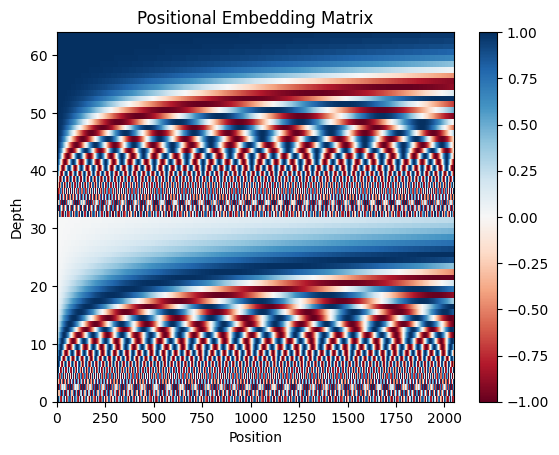


Shape after Self Attention: (32, 6, 64)

Shape after Encoder Feed Forward Layer: (32, 6, 64)

Output shape of the model: (32, 6, 25)

tones2tab initial test:

Input example: [ 0  4 66 32  0  0]
True output: [0 6 8 8 0 6]

tones2tab softmax output: 
E string: tf.Tensor(
[0.09841676 0.02710355 0.04263237 0.05662377 0.01320427 0.01861466
 0.01199265 0.01627885 0.03034417 0.01489265 0.04196436 0.01273626
 0.01166697 0.04170606 0.01874925 0.00641652 0.01063261 0.01362207
 0.06389973 0.01094811 0.12848698 0.10626791 0.00620239 0.03520385
 0.1613933 ], shape=(25,), dtype=float32)
A string: tf.Tensor(
[0.02007217 0.01797978 0.02379897 0.01541867 0.01330745 0.00441428
 0.01324176 0.03979935 0.00812036 0.01510454 0.01047087 0.15737829
 0.02327397 0.01396205 0.03484331 0.05728943 0.0235108  0.07588799
 0.09775621 0.04193501 0.00639704 0.15302551 0.1125568  0.01095818
 0.00949722], shape=(25,), dtype=float32)
D string: tf.Tensor(
[0.01395111 0.00296956 0.01506592 0.04278103 0.09040126 0.00593715


In [20]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

class T2TPositionalEmbedding(Layer):
  def __init__(self, vocab_size=t2t_vocab_length, dim_model=D):
    super().__init__()
    self.d_model = dim_model
    self.embedding = Embedding(input_dim=vocab_size, output_dim=dim_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=dim_model)

  def call(self, x):
    chords = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :chords, :]
    return x

# check position embedding
a = T2TPositionalEmbedding()
a_emb = a(tf.convert_to_tensor(tone_inputs[:batch_size], dtype=tf.int32))
print('Positional embedding example:')
print()
print('Input: ' + str(tone_inputs[0:1].numpy()))
print()
print('Embedding: ' + str(a_emb.numpy()))
print()
print('Embedding shape: ' + str(a_emb.shape))
print()

# check the positional encoding
pos_encoding = positional_encoding(length=2048, depth=D)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.title('Positional Embedding Matrix')
plt.colorbar()
plt.show()

class T2TBaseAttention(Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = MultiHeadAttention(**kwargs)
    self.layernorm = LayerNormalization()
    self.add = Add()

class T2TGlobalSelfAttention(T2TBaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x)
    x = self.add([x, attn_output])
    return self.layernorm(x)

# check gsa
sample_gsa = T2TGlobalSelfAttention(num_heads=H, key_dim=D)
print()
print('Shape after Self Attention: ' + str(sample_gsa(a_emb).shape))
print()

class T2TFeedForward(Layer):
  def __init__(self, dim_model=D, dim_mlp=dff, dropout_rate=dropout_rate):
    super().__init__()
    self.seq = tf.keras.Sequential([
      Dense(dim_mlp, activation='relu'),
      Dense(dim_model),
      Dropout(dropout_rate)
    ])
    self.add = Add()
    self.layer_norm = LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    return self.layer_norm(x)

class T2TEncoder(Layer):
  def __init__(self,*, dim_model=D, num_heads=H, dim_mlp=dff, dropout_rate=dropout_rate):
    super().__init__()
    self.self_attention = T2TGlobalSelfAttention(
        num_heads=num_heads,
        key_dim=dim_model,
        dropout=dropout_rate)
    self.mlp = T2TFeedForward(dim_model=dim_model, dim_mlp=dim_mlp)

  def call(self, x):
    x = self.self_attention(x)
    x = self.mlp(x)
    return x

# check encoder mlp
sample_encoder = T2TEncoder(dim_model=D, num_heads=H, dim_mlp=dff)
print('Shape after Encoder Feed Forward Layer: ' + str(sample_encoder(a_emb).shape))
print()

class Tones2Tab(tf.keras.Model):
    def __init__(self, *, output_dim=t2t_output_dim, dim_model=D, seq_length=N, dim_mlp=dff, L=L, dropout_rate=dropout_rate):
        super().__init__()
        self.dim_model = dim_model
        self.L = L

        self.embed = T2TPositionalEmbedding()
        self.encoder_layers = [T2TEncoder() for _ in range(L)]
        self.dropout = Dropout(dropout_rate)

        self.mlp_head1 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])
        self.mlp_head2 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])
        self.mlp_head3 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])
        self.mlp_head4 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])
        self.mlp_head5 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])
        self.mlp_head6 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])

    def call(self, x): # x is (None, N) where None refers to batch size
        x = self.embed(x) # (None, N, dim_model)
        x = self.dropout(x)
        for i in range(self.L): x = self.encoder_layers[i](x)

        flatten = Flatten()
        x = flatten(x) # (None, N*dim_model)
        s1 = tf.nn.softmax(self.mlp_head1(x)) # (None, number of frets)
        s2 = tf.nn.softmax(self.mlp_head2(x)) # (None, number of frets)
        s3 = tf.nn.softmax(self.mlp_head3(x)) # (None, number of frets)
        s4 = tf.nn.softmax(self.mlp_head4(x)) # (None, number of frets)
        s5 = tf.nn.softmax(self.mlp_head5(x)) # (None, number of frets)
        s6 = tf.nn.softmax(self.mlp_head6(x)) # (None, number of frets)

        # consolidate csf outputs
        y = []
        for i in range(batch_size):
          y.append([s1[i],s2[i],s3[i],s4[i],s5[i],s6[i]])
        out = tf.stack(y)

        return out

# initialize seq2key object
tones2tab = Tones2Tab()
print('Output shape of the model: ' + str(tones2tab(tone_inputs[:batch_size]).shape))
print()
print('tones2tab initial test:')
print()
idx = 8
print('Input example: ' + str(tone_inputs[idx].numpy()))
print('True output: ' + str(tab_outputs[idx].numpy()))
print()
chord = tones2tab(tf.convert_to_tensor(tone_inputs[idx:idx+batch_size], dtype=tf.int32))
s1 = chord[0][0]
s2 = chord[0][1]
s3 = chord[0][2]
s4 = chord[0][3]
s5 = chord[0][4]
s6 = chord[0][5]
print('tones2tab softmax output: ')
print('E string: ' + str(s1))
print('A string: ' + str(s2))
print('D string: ' + str(s3))
print('G string: ' + str(s4))
print('B string: ' + str(s5))
print('e string: ' + str(s6))
print()
print('tones2tab guess: ' + str([int(tf.math.argmax(s1)), int(tf.math.argmax(s2)), int(tf.math.argmax(s3)), int(tf.math.argmax(s4)), int(tf.math.argmax(s5)), int(tf.math.argmax(s6))]))
print()
print('True output is ' + str(tab_outputs[idx:idx+batch_size][0]))
print()

tones2tab.summary()

### tones2tab training prep

Training inputs: tf.Tensor(
[[  0 145   0   1   0   0]
 [  0 129  16   8   0   0]
 [  0 145  16  16   1   0]
 ...
 [  0   0   8 132  80   0]
 [  0  18  65   0   0   0]
 [  0   2   1  18   0   0]], shape=(132800, 6), dtype=int32)

Training outputs: tf.Tensor(
[[ 0  4  3  1  0  1]
 [ 0  4  6  6  0  4]
 [ 9  8  6  6  9  9]
 ...
 [ 0 15 17 17 17 15]
 [ 0  5  3  2  3  0]
 [ 0  5  7  0  6  5]], shape=(132800, 6), dtype=int32)



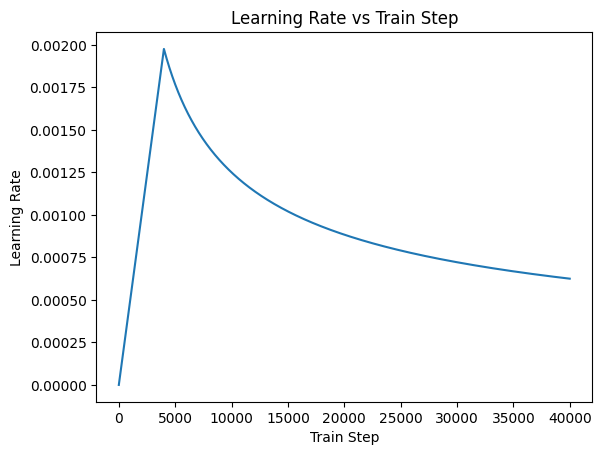

In [21]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, dim_model=D, warmup_steps=4000):
    super().__init__()

    self.dim_model = dim_model
    self.dim_model = tf.cast(self.dim_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return (tf.math.rsqrt(self.dim_model) * tf.math.minimum(arg1, arg2))

# create optimizer
learning_rate = CustomSchedule(dim_model=D)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# plot learning rate
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.title('Learning Rate vs Train Step')
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

# make batches
train_len = 132800
val_len = 14784
test_len = val_len
train_inputs = tone_inputs[:train_len]
train_outputs = tab_outputs[:train_len]
val_inputs = tone_inputs[train_len:train_len+val_len]
val_outputs = tab_outputs[train_len:train_len+val_len]
print('Training inputs: ' + str(train_inputs))
print()
print('Training outputs: ' + str(train_outputs))
print()
test_inputs = tone_inputs[train_len+val_len:train_len+val_len+test_len]
test_outputs = tab_outputs[train_len+val_len:train_len+val_len+test_len]

# define loss and accuracy functions
def loss(truths, preds):
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')
  s1_truths = []
  s1_preds = []
  s2_truths = []
  s2_preds = []
  s3_truths = []
  s3_preds = []
  s4_truths = []
  s4_preds = []
  s5_truths = []
  s5_preds = []
  s6_truths = []
  s6_preds = []
  for i in range(batch_size):
    s1_truths.append(truths[i][0])
    s1_preds.append(preds[i][0])
    s2_truths.append(truths[i][1])
    s2_preds.append(preds[i][1])
    s3_truths.append(truths[i][2])
    s3_preds.append(preds[i][2])
    s4_truths.append(truths[i][3])
    s4_preds.append(preds[i][3])
    s5_truths.append(truths[i][4])
    s5_preds.append(preds[i][4])
    s6_truths.append(truths[i][5])
    s6_preds.append(preds[i][5])
  s1_preds = tf.stack(s1_preds)
  s1_truths = tf.stack(s1_truths)
  s1_loss = tf.reduce_sum(loss_object(s1_truths, s1_preds))
  s2_preds = tf.stack(s2_preds)
  s2_truths = tf.stack(s2_truths)
  s2_loss = tf.reduce_sum(loss_object(s2_truths, s2_preds))
  s3_preds = tf.stack(s3_preds)
  s3_truths = tf.stack(s3_truths)
  s3_loss = tf.reduce_sum(loss_object(s3_truths, s3_preds))
  s4_preds = tf.stack(s4_preds)
  s4_truths = tf.stack(s4_truths)
  s4_loss = tf.reduce_sum(loss_object(s4_truths, s4_preds))
  s5_preds = tf.stack(s5_preds)
  s5_truths = tf.stack(s5_truths)
  s5_loss = tf.reduce_sum(loss_object(s5_truths, s5_preds))
  s6_preds = tf.stack(s6_preds)
  s6_truths = tf.stack(s6_truths)
  s6_loss = tf.reduce_sum(loss_object(s6_truths, s6_preds))
  return tf.add(tf.add(tf.add(tf.add(tf.add(s1_loss,s2_loss),s3_loss),s4_loss),s5_loss),s6_loss)

### tones2tab training

In [22]:
# compile model
tones2tab.compile(loss = loss, optimizer = optimizer, metrics = ['accuracy'])

# train model
tones2tab.fit(train_inputs, train_outputs, batch_size = batch_size, epochs = t2t_epochs, validation_data = (val_inputs, val_outputs))

Epoch 1/10
4150/4150 [==============================] - 135s 28ms/step - loss: 58.1264 - accuracy: 0.9110 - val_loss: 14.5603 - val_accuracy: 0.9758
Epoch 2/10
4150/4150 [==============================] - 148s 36ms/step - loss: 11.0085 - accuracy: 0.9794 - val_loss: 7.5417 - val_accuracy: 0.9835
Epoch 3/10
4150/4150 [==============================] - 171s 41ms/step - loss: 8.4630 - accuracy: 0.9825 - val_loss: 7.2131 - val_accuracy: 0.9837
Epoch 4/10
4150/4150 [==============================] - 147s 35ms/step - loss: 7.6342 - accuracy: 0.9832 - val_loss: 6.7967 - val_accuracy: 0.9849
Epoch 5/10
4150/4150 [==============================] - 112s 27ms/step - loss: 7.1848 - accuracy: 0.9839 - val_loss: 6.5969 - val_accuracy: 0.9846
Epoch 6/10
4150/4150 [==============================] - 113s 27ms/step - loss: 6.9860 - accuracy: 0.9842 - val_loss: 6.5095 - val_accuracy: 0.9852
Epoch 7/10
4150/4150 [==============================] - 112s 27ms/step - loss: 6.8037 - accuracy: 0.9842 - val_loss

In [23]:
# save weights
tones2tab.save_weights('/content/drive/My Drive/Colab/tones2tab')

### tones2tab testing

In [33]:
# upload model weights
temp_model = Tones2Tab()
temp_model.load_weights('/content/drive/My Drive/Colab/tones2tab')
print()

# test specific input sequence
print('tones2tab test:')
print()
idx = 287 # random
print('Test input: ' + str(tone_inputs[idx].numpy()))
print('Tab output: ' + str(tab_outputs[idx].numpy()))
print()
chord = temp_model(tf.convert_to_tensor(tone_inputs[idx:idx+batch_size], dtype=tf.int32))
s1 = chord[0][0]
s2 = chord[0][1]
s3 = chord[0][2]
s4 = chord[0][3]
s5 = chord[0][4]
s6 = chord[0][5]
print('tones2tab softmax output: ')
print('s1: ' + str(s1))
print('s2: ' + str(s2))
print('s3: ' + str(s3))
print('s4: ' + str(s4))
print('s5: ' + str(s5))
print('s6: ' + str(s6))
print()
print('tones2tab guess: ' + str([int(tf.math.argmax(s1)), int(tf.math.argmax(s2)), int(tf.math.argmax(s3)), int(tf.math.argmax(s4)), int(tf.math.argmax(s5)), int(tf.math.argmax(s6))]))
print()
print('True output is ' + str(tab_outputs[idx].numpy()))
print()

# test model on user-defined tone
tab = [0,4,6,6,5,4]
tones = tab2freqs(tab)
print('User-defined tab: ' + str(tab))
print()
chord = temp_model(tf.convert_to_tensor([tones for i in range(batch_size)], dtype=tf.int32))
s1 = chord[0][0]
s2 = chord[0][1]
s3 = chord[0][2]
s4 = chord[0][3]
s5 = chord[0][4]
s6 = chord[0][5]
print('tones2tab softmax output: ')
print('s1: ' + str(s1))
print('s2: ' + str(s2))
print('s3: ' + str(s3))
print('s4: ' + str(s4))
print('s5: ' + str(s5))
print('s6: ' + str(s6))
print()
print('tones2tab guess: ' + str([int(tf.math.argmax(s1)), int(tf.math.argmax(s2)), int(tf.math.argmax(s3)), int(tf.math.argmax(s4)), int(tf.math.argmax(s5)), int(tf.math.argmax(s6))]))
print()

temp_model.summary()


tones2tab test:

Test input: [ 0 16  8  9 17  0]
Tab output: [13 15 15 13 13 13]

tones2tab softmax output: 
s1: tf.Tensor(
[4.1998538e-07 2.3695395e-18 2.3080914e-31 2.1246418e-25 1.9248280e-18
 6.0546176e-18 2.5383446e-19 3.1288983e-24 8.8780064e-17 1.7797905e-15
 1.6915812e-17 2.4359715e-16 7.7049897e-18 9.9999952e-01 2.9059682e-18
 2.2794106e-15 3.4859998e-17 5.0154184e-17 2.8160974e-19 1.8774361e-19
 2.6740808e-19 1.4482211e-19 3.7757223e-19 2.4742717e-19 2.6082426e-19], shape=(25,), dtype=float32)
s2: tf.Tensor(
[4.7201054e-05 2.9801769e-22 1.7890591e-16 1.3568867e-16 1.3692209e-15
 5.7290002e-19 3.2511327e-11 6.8828743e-10 3.4630478e-09 1.6316452e-10
 7.8459366e-12 3.2604446e-09 5.2850564e-11 2.3550632e-08 7.1401347e-14
 9.9995279e-01 3.9835193e-09 1.9735893e-15 5.8472204e-16 3.7979999e-16
 4.7622686e-16 3.3963975e-16 5.2570131e-16 5.6469050e-16 3.4187817e-16], shape=(25,), dtype=float32)
s3: tf.Tensor(
[3.5257282e-05 7.3587254e-20 8.0268423e-09 1.1222108e-08 1.6641291e-11
 1.0